#**🚨 Before Running the Script Please Make Sure you have selected the Run Time as GPU**

#**Step 01: Installing the Packages**

In [2]:
%%capture
!pip install -q git+https://github.com/Deci-AI/super-gradients.git@stable
!pip install -q roboflow
!pip install -q supervision
!pip install imutils
!pip install pytube --upgrade

In [1]:
1

1

In [3]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='sign_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

[2023-12-16 19:21:26] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-12-16 19:21:26] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-12-16 19:21:29] INFO - utils.py - NumExpr defaulting to 4 threads.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-12-16 19:21:44] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-12-16 19:21:44] WARNING - export.py - Failed to import pytorch_quantization
[2023-12-16 19:21:44] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-12-16 19:21:44] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IuYv6KOKs5p62rFSLvGa")
project = rf.workspace("david-lee-d0rhs").project("american-sign-language-letters")
dataset = project.version(6).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch::  20%|█▉        | 284/1452 [00:00<00:00, 2830.68it/s]

In [6]:
dataset_params = {
    'data_dir':'/kaggle/working/American-Sign-Language-Letters-6',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'J', 'K', 'L','M','N','O', 'P', 'Q', 'R', 'S', 'T', 'U',  'V', 'W', 'X', 'Y', 'Z']
}



Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch:: 100%|██████████| 1452/1452 [00:00<00:00, 3751.50it/s]


In [9]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [10]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

Indexing dataset annotations: 100%|██████████| 72/72 [00:00<00:00, 4983.33it/s]


In [11]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [12]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

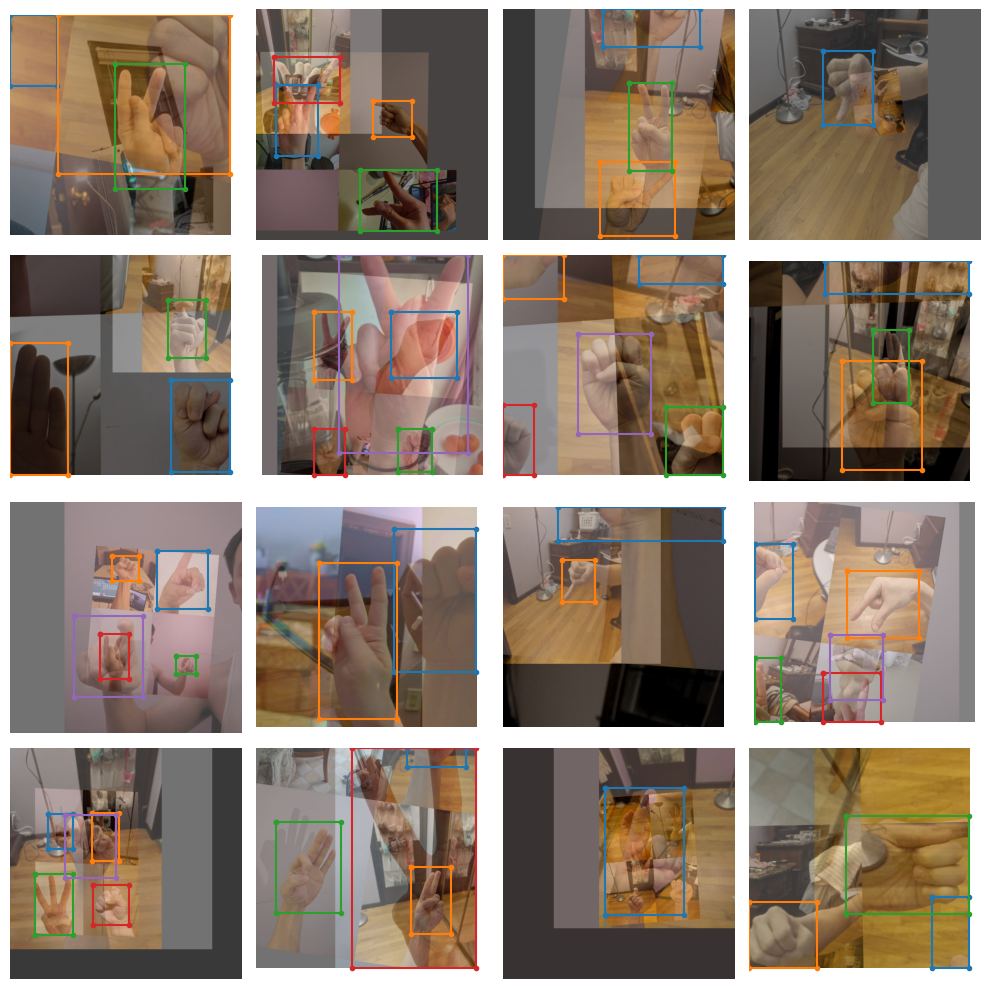

In [13]:
train_data.dataset.plot()

In [14]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-12-16 19:25:23] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:02<00:00, 37.3MB/s]
[2023-12-16 19:25:26] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [15]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 25,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [16]:
!wget "https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t"
!wget "https://drive.google.com/uc?id=1kju9OOo05c5XTfrKuLvsZcxu_NPloQk_&confirm=t"

--2023-12-16 19:25:27--  https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.101, 74.125.195.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m67ebl7cjle4aq07ek3brpoid779mtlm/1702754700000/08996309138817722690/*/1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ?uuid=2fe2634d-d9e2-4bf7-be6c-dacf1edb454d [following]
--2023-12-16 19:25:27--  https://doc-04-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m67ebl7cjle4aq07ek3brpoid779mtlm/1702754700000/08996309138817722690/*/1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ?uuid=2fe2634d-d9e2-4bf7-be6c-dacf1edb454d
Resolving doc-04-bo-docs.googleusercontent.com (doc-04-bo-docs.googleusercontent.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting

In [17]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-12-16 19:25:34] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231216_192534_773698`
[2023-12-16 19:25:34] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/sign_yolonas_run2/RUN_20231216_192534_773698
[2023-12-16 19:25:34] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/sign_yolonas_run2/RUN_20231216_192534_773698/console_Dec16_19_25_34.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
[2023-12-16 19:25:41] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            504        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         31      

In [19]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/kaggle/working/checkpoints2/sign_yolonas_run2/RUN_20231216_192534_773698/ckpt_best.pth")

[2023-12-16 19:54:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/checkpoints2/sign_yolonas_run2/RUN_20231216_192534_773698/ckpt_best.pth EMA checkpoint.


In [20]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 5/5 [00:02<00:00,  2.76it/s]

{'PPYoloELoss/loss_cls': 0.8160294,
 'PPYoloELoss/loss_iou': 0.15307683,
 'PPYoloELoss/loss_dfl': 0.34644333,
 'PPYoloELoss/loss': 1.3155496,
 'Precision@0.50': 0.09994196146726608,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.8770148754119873,
 'F1@0.50': 0.17497217655181885}

Testing: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


[2023-12-16 19:55:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


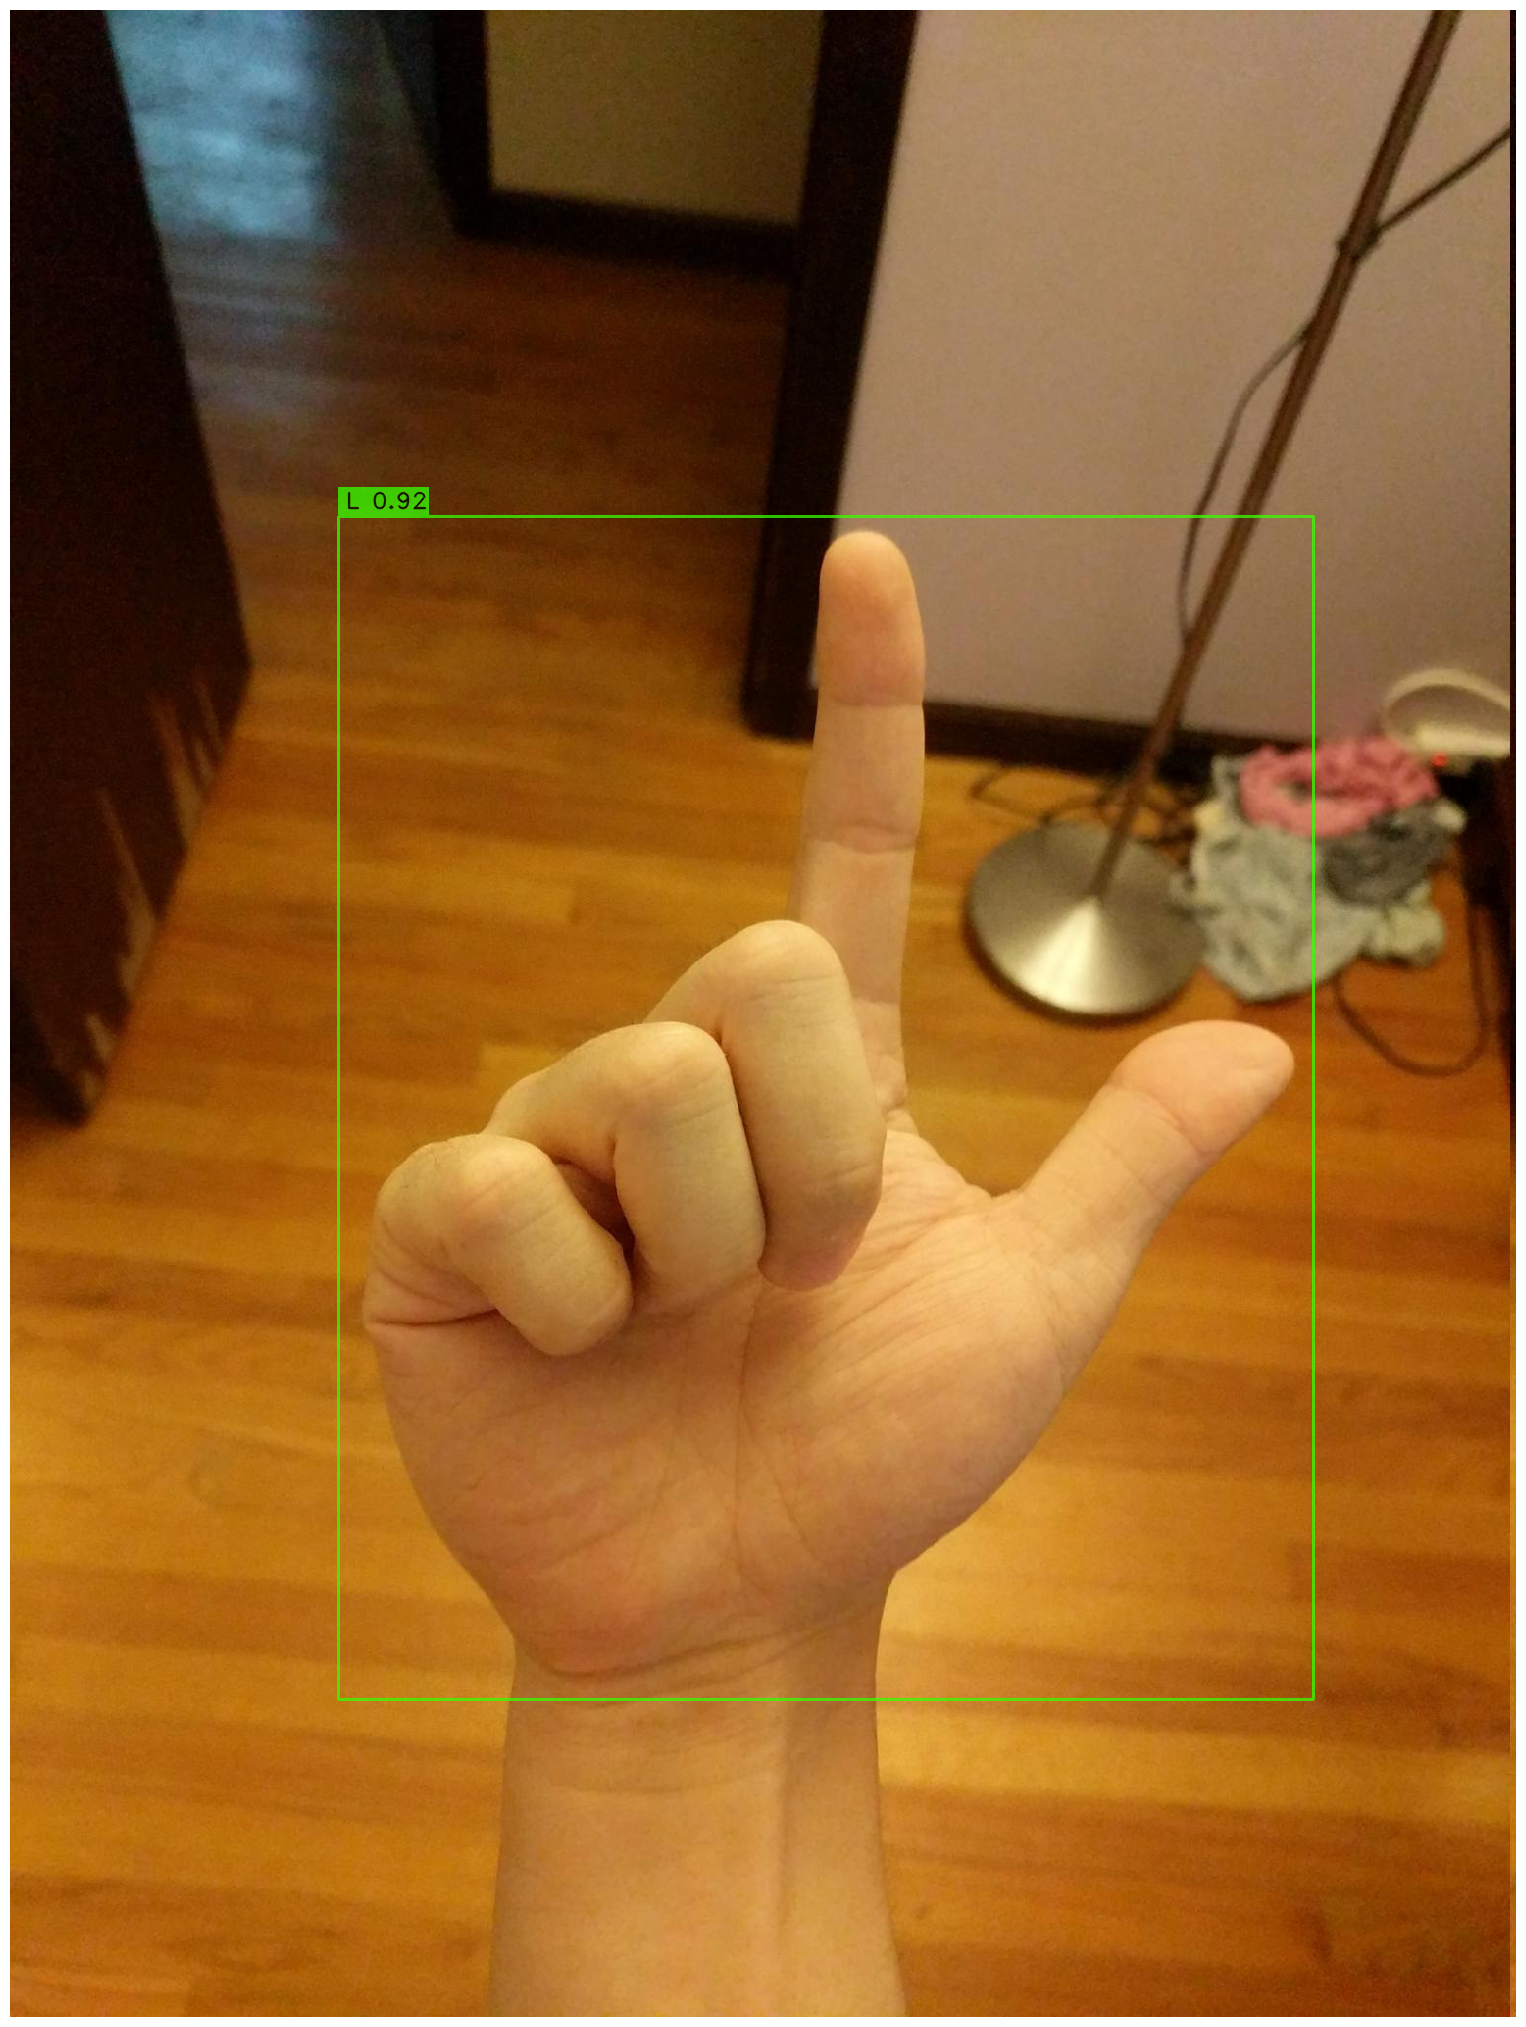

In [21]:
img_url = '/kaggle/working/American-Sign-Language-Letters-6/train/images/L0_jpg.rf.eda79b4a90a9752fc059369bec144428.jpg'
result=best_model.predict(img_url).show()

In [54]:
result=best_model.predict(img_url)
image_info= result._images_prediction_lst[0]

image_data = image_info.image

detection_info = image_info.prediction
bounding_boxes = detection_info.bboxes_xyxy
confidence_scores = detection_info.confidence
labels = detection_info.labels

class_names = [image_info.class_names[int(label)] for label in labels]

# Print or use the extracted information as needed
print("Image Data:\n", image_data)
print("Bounding Boxes:\n", bounding_boxes)
print("Confidence Scores:\n", confidence_scores)
print("Labels:\n", labels)
print("Class Names:\n", class_names)


Image Data:
 [[[ 24   3   0]
  [ 25   4   0]
  [ 27   6   1]
  ...
  [ 13   3   1]
  [ 10   4   6]
  [  6   4   7]]

 [[ 24   3   0]
  [ 25   4   0]
  [ 27   6   1]
  ...
  [ 13   2   0]
  [  9   3   5]
  [  5   3   6]]

 [[ 23   4   0]
  [ 24   5   0]
  [ 26   7   1]
  ...
  [ 11   0   0]
  [  9   3   3]
  [  7   3   4]]

 ...

 [[192 103  23]
  [191 102  22]
  [189 100  20]
  ...
  [192 107  24]
  [191 109  23]
  [192 111  22]]

 [[192 103  23]
  [190 101  21]
  [188  99  19]
  ...
  [191 106  23]
  [187 105  19]
  [187 106  17]]

 [[190 101  19]
  [189 100  18]
  [186  97  15]
  ...
  [190 105  22]
  [187 105  19]
  [186 106  17]]]
Bounding Boxes:
 [[ 335.43613  517.3472  1328.9508  1723.9578 ]]
Confidence Scores:
 [0.923]
Labels:
 [11.]
Class Names:
 ['L']
